In [ ]:
import tensorflow as tf 
from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model


def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [ ]:
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

169017344/169001437 [==============================] - 7s 0us/step
x_train: 50000 x_test: 10000


In [ ]:
def plain_conv_block(input_tensor,
               filters,
               stage,
               block,
               strides=(2,2),
               use_l2_regularizer=True,
               bn_decay=0.9,
               bn_epsilon=1e-5):
  

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_name='conv'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters,(3,3),strides=strides,padding='same',use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = conv_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis, momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2a')(x)

  x = layers.Activation('relu')(x)
  
  x = layers.Conv2D(filters,(3,3),use_bias=False,padding='same',kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = conv_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis, momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  return x

In [ ]:
def plain_identity_block(input_tensor,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   bn_decay=0.9,
                   bn_epsilon=1e-5):
  
  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_name='id'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters,(3,3),padding='same',use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters,(3,3),padding='same',use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_name+'2b')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2b')(x)
  
  x = layers.Activation('relu')(x)

  return x

In [ ]:
def plain18(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             bn_decay=0.9,
             bn_epsilon=1e-5):
 

  input_shape = (32, 32, 3) 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)
  if rescale_inputs:
  
    x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(
            imagenet_preprocessing.CHANNEL_MEANS,
            shape=[1, 1, 3],
            dtype=x.dtype),
        name='rescale')(
            img_input)
  else:
    x = img_input

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(x)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      bn_decay=bn_decay,
      bn_epsilon=bn_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=bn_decay,
      epsilon=bn_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = plain_identity_block(x, 64, stage=2, block='a', **block_config)
  x = plain_identity_block(x, 64, stage=2, block='b', **block_config)

  x = plain_conv_block(x,128, stage=3, block='a', **block_config)
  x = plain_identity_block(x, 128, stage=3, block='b', **block_config)

  x = plain_conv_block(x,256, stage=4, block='a', **block_config)
  x = plain_identity_block(x,256, stage=4, block='b', **block_config)

  x = plain_conv_block(x,512, stage=5, block='a', **block_config)
  x = plain_identity_block(x, 512, stage=5, block='b', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  x = layers.Activation('softmax', dtype='float32')(x)

  return models.Model(img_input, x, name='plain18')

In [ ]:
plain_18 = plain18(num_classes=100)
plain_18.summary()

Model: "plain18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 64)        9408      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 16, 16, 64)       256       
 n)                                                              
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                         

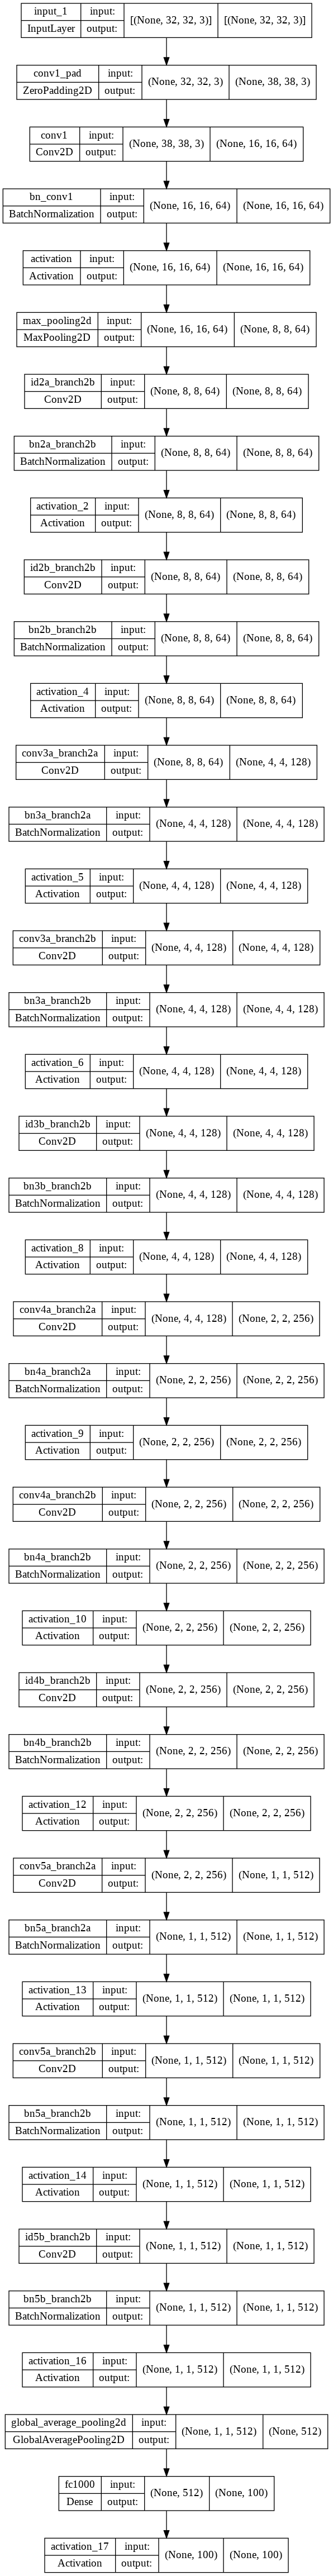

In [ ]:
plot_model(plain_18,show_shapes=True)

In [ ]:
plain_18.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_plain18 = plain_18.fit(x_train, y_train, epochs=1000)

In [ ]:
def conv_block(input_tensor,
               filters,
               stage,
               block,
               strides=(2,2),
               use_l2_regularizer=True,
               bn_decay=0.9,
               bn_epsilon=1e-5):
  

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_name='conv'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters,(3,3),strides=strides,padding='same',use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = conv_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis, momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2a')(x)

  x = layers.Activation('relu')(x)
  
  x = layers.Conv2D(filters,(3,3),use_bias=False,padding='same',kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = conv_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis, momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2b')(x)


  shortcut = layers.Conv2D(filters,(3,3),strides=strides,padding='same',use_bias=False,kernel_initializer='he_normal',
                           kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                           name = conv_name+'1')(input_tensor)

  shortcut = layers.BatchNormalization(axis=bn_axis, momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'1')(shortcut)

  x = layers.add([x, shortcut])

  x = layers.Activation('relu')(x)

  return x

In [ ]:
def identity_block(input_tensor,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   bn_decay=0.9,
                   bn_epsilon=1e-5):
  
  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_name='id'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters,(3,3),padding='same',use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters,(3,3),padding='same',use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,momentum=bn_decay, epsilon=bn_epsilon,name=bn_name+'2b')(x)

  x = layers.add([x,input_tensor])
  
  x = layers.Activation('relu')(x)

  return x

In [ ]:
def resnet18(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             bn_decay=0.9,
             bn_epsilon=1e-5):

  input_shape = (32, 32, 3)
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)
  if rescale_inputs:
    x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(
            imagenet_preprocessing.CHANNEL_MEANS,
            shape=[1, 1, 3],
            dtype=x.dtype),
        name='rescale')(
            img_input)
  else:
    x = img_input

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(x)
    bn_axis = 1
  else:  
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      bn_decay=bn_decay,
      bn_epsilon=bn_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=bn_decay,
      epsilon=bn_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = identity_block(x, 64, stage=2, block='a', **block_config)
  x = identity_block(x, 64, stage=2, block='b', **block_config)

  x = conv_block(x,128, stage=3, block='a', **block_config)
  x = identity_block(x, 128, stage=3, block='b', **block_config)

  x = conv_block(x,256, stage=4, block='a', **block_config)
  x = identity_block(x,256, stage=4, block='b', **block_config)

  x = conv_block(x,512, stage=5, block='a', **block_config)
  x = identity_block(x, 512, stage=5, block='b', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  x = layers.Activation('softmax', dtype='float32')(x)

  return models.Model(img_input, x, name='resnet18')

In [ ]:
resnet_18 = resnet18(num_classes=100)
resnet_18.summary()

Model: "resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9408        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

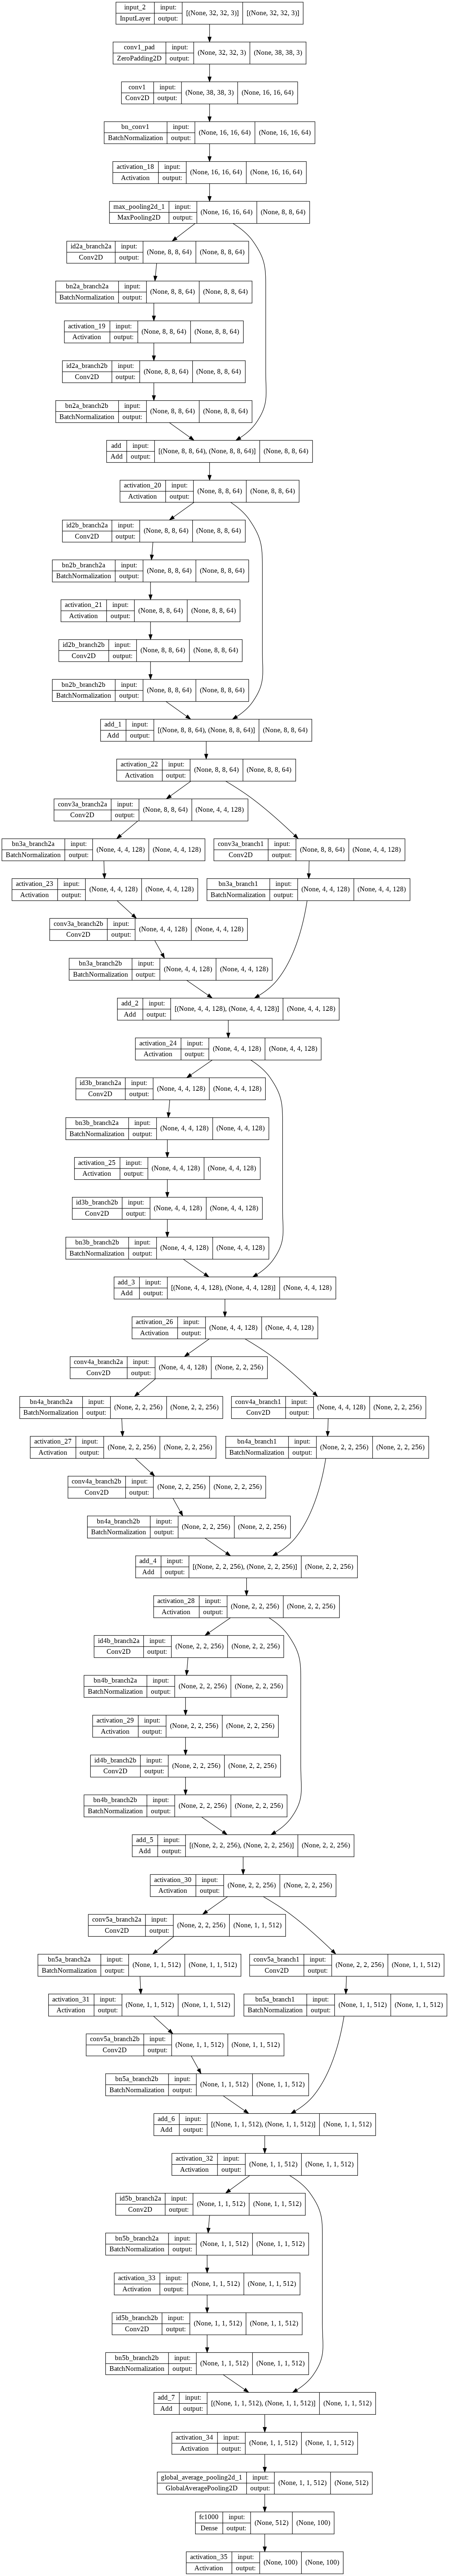

In [ ]:
plot_model(resnet_18, show_shapes=True)

In [ ]:
resnet_18.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_resnet18 = resnet_18.fit(x_train, y_train, epochs=1000)

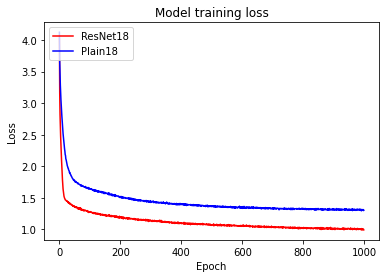

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet18.history['loss'], 'r')
plt.plot(history_plain18.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet18','Plain18'], loc='upper left')
plt.show()

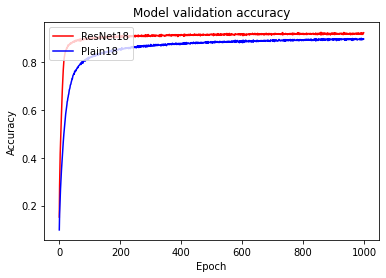

In [ ]:
plt.plot(history_resnet18.history['accuracy'], 'r')
plt.plot(history_plain18.history['accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet18', 'Plain18'], loc='upper left')
plt.show()